<div>
<font size=4> Description </font> <br>
    a code to give value to null data, based on multiple imputation. 
</div>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fancyimpute import KNN
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
df = pd.read_csv('prepared_with_null_fix_DC.csv')
df['BC'] *= 10 # Categorical
df.head(10)

,Y,AF,AQ,AY,BC,BE,BG,BH,BI,BL,...,DE,DT,DW,DX,DY,EZ,Age,metastasis,dead,secondprim
0,1.0,1.0,4.0,NaN,NaN,NaN,2.0,1.0,1.0,NaN,...,10.0,2.0,2.0,2.0,2.0,103.0,44.0,NaN,1.0,2.0
1,1.0,2.0,4.0,2.0,NaN,NaN,2.0,1.0,1.0,NaN,...,1.0,1.0,2.0,1.0,1.0,153.0,51.0,2.0,1.0,2.0
2,2.0,2.0,4.0,NaN,45.0,NaN,2.0,1.0,1.0,NaN,...,1.0,2.0,2.0,2.0,2.0,160.0,53.0,2.0,1.0,2.0
3,2.0,2.0,2.0,3.0,NaN,NaN,2.0,1.0,1.0,NaN,...,10.0,2.0,2.0,2.0,2.0,115.0,59.0,NaN,1.0,2.0
4,1.0,2.0,4.0,NaN,NaN,NaN,2.0,1.0,1.0,NaN,...,10.0,2.0,2.0,2.0,2.0,52.0,40.0,2.0,1.0,2.0
5,2.0,2.0,6.0,NaN,NaN,NaN,2.0,1.0,1.0,NaN,...,10.0,2.0,2.0,2.0,2.0,298.0,33.0,NaN,1.0,2.0
6,2.0,2.0,2.0,2.0,NaN,NaN,1.0,1.0,2.0,1.0,...,10.0,2.0,2.0,2.0,2.0,168.0,83.0,NaN,1.0,2.0
7,2.0,2.0,2.0,2.0,50.0,5.0,1.0,1.0,1.0,1.0,...,10.0,2.0,2.0,2.0,2.0,162.0,80.0,NaN,1.0,2.0
8,2.0,2.0,2.0,3.0,30.0,NaN,1.0,1.0,2.0,1.0,...,1.0,1.0,1.0,1.0,2.0,76.0,71.0,2.0,1.0,2.0
9,1.0,2.0,NaN,NaN,NaN,NaN,2.0,1.0,1.0,NaN,...,10.0,2.0,2.0,2.0,2.0,225.0,57.0,NaN,1.0,2.0


Text(0.5, 1.0, 'dead patients')

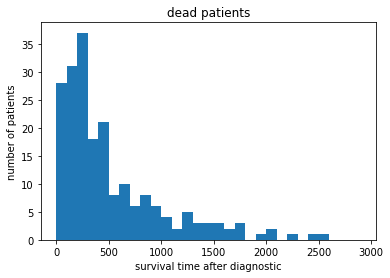

In [3]:
plt.hist(df[df['dead'] == 1]['EZ'], bins = range(0, 3000, 100))
plt.xlabel('survival time after diagnostic')
plt.ylabel('number of patients')
plt.title('dead patients')

Text(0.5, 1.0, 'alive patients')

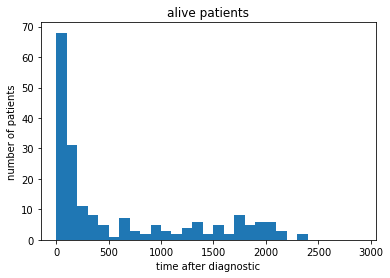

In [4]:
plt.hist(df[df['dead'] == 2]['EZ'], bins = range(0, 3000, 100))
plt.xlabel('time after diagnostic')
plt.ylabel('number of patients')
plt.title('alive patients')

In [5]:
# get insight about number of null values
pd.DataFrame(df.shape[0] - df.count())

,0
Y,41
AF,36
AQ,28
AY,111
BC,141
BE,414
BG,5
BH,51
BI,65
BL,88


In [6]:
# get insight about different values that our features can acquire

cols = list(df.columns)
cols.remove('Age')
cols.remove('EZ')

for col in cols:
    print(df[col].value_counts())

# Binary = All - Categorical - Numerical
# Categorical = AY, DE ---> AQ, DE
# Numerical = AY, BC, BE, EZ, Age

2.0    431
1.0     54
Name: Y, dtype: int64
2.0    386
1.0    104
Name: AF, dtype: int64
2.0     315
1.0      91
6.0      37
4.0      33
3.0       7
10.0      5
9.0       4
5.0       4
7.0       1
11.0      1
Name: AQ, dtype: int64
2.0    233
3.0    160
4.0     22
Name: AY, dtype: int64
30.0     47
20.0     46
15.0     37
40.0     34
10.0     31
25.0     27
50.0     24
35.0     22
45.0     13
70.0     11
60.0     10
12.0      8
55.0      7
5.0       6
18.0      5
22.0      4
17.0      4
80.0      4
13.0      4
7.0       4
28.0      3
14.0      3
100.0     3
24.0      3
38.0      3
41.0      2
9.0       2
90.0      2
32.0      2
3.0       2
65.0      2
8.0       2
11.0      1
19.0      1
37.0      1
23.0      1
26.0      1
46.0      1
53.0      1
6.0       1
Name: BC, dtype: int64
1.0     39
2.0     27
3.0     16
4.0      6
6.0      6
5.0      5
7.0      4
8.0      3
9.0      2
12.0     2
10.0     1
16.0     1
Name: BE, dtype: int64
1.0    432
2.0     89
Name: BG, dtype: int64
1.0    34

<font size=4>Fancy Imputer based on KNN </font><br>
$k = 10$ is set.

In [7]:
imputer = KNN(k=11, orientation='rows', print_interval=100, verbose=True)
encode_data = pd.DataFrame(np.round(imputer.fit_transform(df)), columns = df.columns)
encode_data['BC'] /= 10
imp = encode_data

Imputing row 1/526 with 7 missing, elapsed time: 0.113
Imputing row 101/526 with 12 missing, elapsed time: 0.120
Imputing row 201/526 with 5 missing, elapsed time: 0.127
Imputing row 301/526 with 3 missing, elapsed time: 0.138
Imputing row 401/526 with 1 missing, elapsed time: 0.147
Imputing row 501/526 with 9 missing, elapsed time: 0.156


In [8]:
imp.head(10)

,Y,AF,AQ,AY,BC,BE,BG,BH,BI,BL,...,DE,DT,DW,DX,DY,EZ,Age,metastasis,dead,secondprim
0,1.0,1.0,4.0,3.0,6.9,3.0,2.0,1.0,1.0,1.0,...,10.0,2.0,2.0,2.0,2.0,103.0,44.0,2.0,1.0,2.0
1,1.0,2.0,4.0,2.0,4.3,7.0,2.0,1.0,1.0,1.0,...,1.0,1.0,2.0,1.0,1.0,153.0,51.0,2.0,1.0,2.0
2,2.0,2.0,4.0,2.0,4.5,6.0,2.0,1.0,1.0,1.0,...,1.0,2.0,2.0,2.0,2.0,160.0,53.0,2.0,1.0,2.0
3,2.0,2.0,2.0,3.0,5.4,3.0,2.0,1.0,1.0,1.0,...,10.0,2.0,2.0,2.0,2.0,115.0,59.0,2.0,1.0,2.0
4,1.0,2.0,4.0,3.0,3.7,4.0,2.0,1.0,1.0,1.0,...,10.0,2.0,2.0,2.0,2.0,52.0,40.0,2.0,1.0,2.0
5,2.0,2.0,6.0,3.0,2.5,3.0,2.0,1.0,1.0,1.0,...,10.0,2.0,2.0,2.0,2.0,298.0,33.0,2.0,1.0,2.0
6,2.0,2.0,2.0,2.0,3.8,4.0,1.0,1.0,2.0,1.0,...,10.0,2.0,2.0,2.0,2.0,168.0,83.0,2.0,1.0,2.0
7,2.0,2.0,2.0,2.0,5.0,5.0,1.0,1.0,1.0,1.0,...,10.0,2.0,2.0,2.0,2.0,162.0,80.0,2.0,1.0,2.0
8,2.0,2.0,2.0,3.0,3.0,3.0,1.0,1.0,2.0,1.0,...,1.0,1.0,1.0,1.0,2.0,76.0,71.0,2.0,1.0,2.0
9,1.0,2.0,3.0,3.0,3.6,3.0,2.0,1.0,1.0,1.0,...,10.0,2.0,2.0,2.0,2.0,225.0,57.0,2.0,1.0,2.0


get insight about the performence of imputer by comparing distributions in data.

In [9]:
def get_pie_chart(df, c_name):
    col = df[c_name]
    s = col.value_counts()
    indices = s.index
    values = s.to_numpy()
    return values, indices

[431  54]


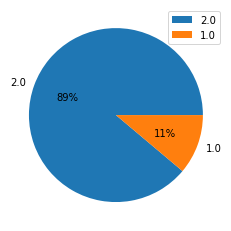

In [10]:
data, label = get_pie_chart(df, 'Y')
plt.pie(data, labels=label, autopct='%1.00f%%')
plt.legend()
print(np.array(data))
pass

[467  59]


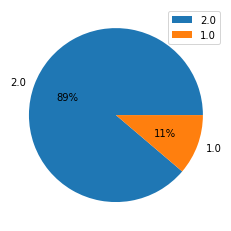

In [11]:
data, label = get_pie_chart(imp, 'Y')
plt.pie(data, labels=label, autopct='%1.0f%%')
plt.legend()
print(np.array(data))
pass

In [12]:
imp.to_csv('prepared_for_rsf_KNN_imputation.csv', index=False)

In [13]:
imputer = IterativeImputer(max_iter=20, random_state=0)
numpy_df = df.to_numpy()
imputer.fit(numpy_df)
imp = pd.DataFrame(np.round(imputer.transform(numpy_df)), columns = df.columns)
imp['BC'] /= 10
imp.head(10)

,Y,AF,AQ,AY,BC,BE,BG,BH,BI,BL,...,DE,DT,DW,DX,DY,EZ,Age,metastasis,dead,secondprim
0,1.0,1.0,4.0,3.0,3.0,3.0,2.0,1.0,1.0,2.0,...,10.0,2.0,2.0,2.0,2.0,103.0,44.0,2.0,1.0,2.0
1,1.0,2.0,4.0,2.0,3.5,3.0,2.0,1.0,1.0,2.0,...,1.0,1.0,2.0,1.0,1.0,153.0,51.0,2.0,1.0,2.0
2,2.0,2.0,4.0,3.0,4.5,3.0,2.0,1.0,1.0,2.0,...,1.0,2.0,2.0,2.0,2.0,160.0,53.0,2.0,1.0,2.0
3,2.0,2.0,2.0,3.0,3.1,3.0,2.0,1.0,1.0,2.0,...,10.0,2.0,2.0,2.0,2.0,115.0,59.0,2.0,1.0,2.0
4,1.0,2.0,4.0,3.0,3.1,3.0,2.0,1.0,1.0,2.0,...,10.0,2.0,2.0,2.0,2.0,52.0,40.0,2.0,1.0,2.0
5,2.0,2.0,6.0,3.0,3.1,3.0,2.0,1.0,1.0,2.0,...,10.0,2.0,2.0,2.0,2.0,298.0,33.0,2.0,1.0,2.0
6,2.0,2.0,2.0,2.0,3.2,3.0,1.0,1.0,2.0,1.0,...,10.0,2.0,2.0,2.0,2.0,168.0,83.0,2.0,1.0,2.0
7,2.0,2.0,2.0,2.0,5.0,5.0,1.0,1.0,1.0,1.0,...,10.0,2.0,2.0,2.0,2.0,162.0,80.0,2.0,1.0,2.0
8,2.0,2.0,2.0,3.0,3.0,3.0,1.0,1.0,2.0,1.0,...,1.0,1.0,1.0,1.0,2.0,76.0,71.0,2.0,1.0,2.0
9,1.0,2.0,5.0,3.0,3.1,3.0,2.0,1.0,1.0,2.0,...,10.0,2.0,2.0,2.0,2.0,225.0,57.0,2.0,1.0,2.0


In [14]:
imp.to_csv('prepared_for_rsf_Iterative_imputation.csv', index=False)